In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
def createGraph(depotNodes ,requiredEdges, numNodes, show=True):
    G = nx.Graph()
    edges = []
    pos = {}
    reqPos = {}
    s = [1, 1, 2, 2, 3, 3, 4, 4, 4, 5, 6, 7]
    t = [2, 3, 4, 6, 4, 5, 5, 7, 6, 8, 7, 8]
    weights = [2.3, 2, 3, 1.5, 3.2, 2.2, 3.8, 2.6, 2.2, 2.8, 1.8, 0.8]
    xData = [-2, -0.5, -1,   0, 1,  1.5, 2,   2.5];
    yData = [ 0, -2,    2.5, 0, 3, -2,   0.3, 1.5];
    for i in range(len(s)):
        edges.append((s[i], t[i], weights[i]))
    
    for i in range(1, numNodes+1):
        G.add_node(i)
        pos[i] =(xData[i-1], yData[i-1])
    
    node_color = ['y']*int(G.number_of_nodes())
    depot_node_color = node_color
    for i in range(1, len(node_color)+1):
        if i in depotNodes:
            depot_node_color[i-1] = 'g'
            
    G.add_weighted_edges_from(edges)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx(G,pos, node_color = node_color)
    nx.draw_networkx(G,pos, node_color = depot_node_color)
    nx.draw_networkx_edges(G, pos, edgelist=requiredEdges, width=3, alpha=0.5,
                                        edge_color="r")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    if show:
        plt.figure(1)
        plt.show()
    return G,pos, depot_node_color

In [47]:
def drawGraph(G, depotNodes, requiredEdges):
    pos = {}
    node_color = ['y']*int(G.number_of_nodes())
    depot_node_color = node_color
    s = [1, 1, 2, 2, 3, 3, 4, 4, 4, 5, 6, 7]
    t = [2, 3, 4, 6, 4, 5, 5, 7, 6, 8, 7, 8]
    weights = [2.3, 2, 3, 1.5, 3.2, 2.2, 3.8, 2.6, 2.2, 2.8, 1.8, 0.8]
    xData = [-2, -0.5, -1,   0, 1,  1.5, 2,   2.5];
    yData = [ 0, -2,    2.5, 0, 3, -2,   0.3, 1.5];
    
    for i in range(len(s)):
        if not G.has_edge(s[i],t[i]):
            del weights[i]
    
    for i in range(1, len(node_color)+1):
        if i in depotNodes:
            depot_node_color[i-1] = 'g'
    
    for i in range(1, len(G.nodes())+1):
        pos[i] =(xData[i-1], yData[i-1])
    
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx(G,pos, node_color = node_color)
    nx.draw_networkx(G,pos, node_color = depot_node_color)
    nx.draw_networkx_edges(G, pos, edgelist=requiredEdges, width=3, alpha=0.5,
                                        edge_color="r")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.figure(1)
    plt.show()

In [48]:
# Allocating task based on distance between base station and desired edge and UAV availability
def taskAllocation(G, depotNodes, requiredNodes, numrequiredEdges, uavsInDepotNodes):
    depotNodesCost = np.zeros((len(depotNodes), numrequiredEdges))
    depotPath = []
    bestPathTillDesiredEdge = []
    bestCostTillDesiredEdge = []

    for j in range(numrequiredEdges):
        for i in range(len(depotNodes)):
            c1 = nx.dijkstra_path_length(G, source=depotNodes[i], target=requiredNodes[j][0])
            c2 = nx.dijkstra_path_length(G, source=depotNodes[i], target=requiredNodes[j][1])
            l = []
            if c1 <= c2:
                l = nx.dijkstra_path(G, source=depotNodes[i], target=requiredNodes[j][0])
                l.append(requiredNodes[j][1])
            else:
                l = nx.dijkstra_path(G, source=depotNodes[i], target=requiredNodes[j][1])
                l.append(requiredNodes[j][0])
            depotNodesCost[i,j] = min(c1,c2)
            depotNodesCost[i,j] += G.get_edge_data(requiredNodes[j][0], requiredNodes[j][1])['weight']
            depotPath.append(l)
            
        if uavsInDepotNodes[np.argmin(depotNodesCost[:,j])] > 0:
                uavsInDepotNodes[np.argmin(depotNodesCost[:,j])] -= 1
        else:
            depotNodesCost[np.argmin(depotNodesCost[:,j]),j] = np.inf
    
    depotPath = np.transpose(np.array(depotPath, dtype=object).reshape((numrequiredEdges, len(depotNodes))))
    taskAllocatedtoBaseStations = []
    print("Task Allocation Algorithm Output: ")
    for i in range(numrequiredEdges):
        taskAllocatedtoBaseStations.append(np.argmin(depotNodesCost[:,i]))
        bestCostTillDesiredEdge.append(depotNodesCost[taskAllocatedtoBaseStations[i],i])
        bestPathTillDesiredEdge.append(depotPath[taskAllocatedtoBaseStations[i],i])
        print('Allocating arc ' + str(requiredNodes[i][0]) + ' - ' + str(requiredNodes[i][1]) + ' to base station - node ' + str(depotNodes[taskAllocatedtoBaseStations[i]]))
    
    return bestPathTillDesiredEdge, bestCostTillDesiredEdge

In [49]:
def visualizePath(depotNodes, requiredNodes, numNodes, path, pathType="solution"):
    plt.figure(1)
    for j in range(len(path)):
        if path[j] != None:
#             plt.figure(j+1)
            G, pos, depot_node_color = createGraph(depotNodes, requiredNodes , numNodes, show=False)
            G1 = nx.DiGraph()
            pos1 = {}
            node_color = []
            edges = []
            for i in range(len(path[j])-1):
                edges.append((path[j][i], path[j][i+1], G.get_edge_data(path[j][i], path[j][i+1])['weight']))
                pos1[path[j][i]] = pos[path[j][i]]
                if i == len(path[j])-2:
                    pos1[path[j][i+1]] = pos[path[j][i+1]]

            for key in pos1.keys():
                node_color.append(depot_node_color[key-1])

            G1.add_weighted_edges_from(edges)
            nx.draw_networkx(G1,pos1, arrows=True, node_color = node_color, edge_color='b', arrowsize=12, width=1, arrowstyle='simple')
            if pathType == "solution":
                plt.legend(["Solution Path"], loc ="upper left")
            else:
                plt.legend(["Path"], loc ="upper left")
            plt.show()

In [52]:
def constructAndStrike(G, numrequiredEdges, requiredNodes, depotNodes, bestPathTillDesiredEdge, bestCostTillDesiredEdge, vehicleCapacity):
    bestRoute = []
    bestRouteCost = []
    minCost = np.inf
    for j in range(numrequiredEdges):
        minCost = np.inf
        l = []
        for i in range(len(depotNodes)):
            c1 = nx.dijkstra_path_length(G, source=bestPathTillDesiredEdge[j][-1], target=depotNodes[i])
            if c1 <= minCost:
                l = nx.dijkstra_path(G, source=bestPathTillDesiredEdge[j][-1], target=depotNodes[i])[1:]
                minCost = c1
        bestRoute.append(bestPathTillDesiredEdge[j] + l)
        bestRouteCost.append(bestCostTillDesiredEdge[j] + minCost)
        if bestRouteCost[j] > vehicleCapacity:
            bestRoute[j] = None
            bestRouteCost[j] = np.inf       #---Construct Phase----#
            
        if bestRoute[j] is not None:
            visualizePath(depotNodes, requiredNodes, numNodes, [bestRoute[j]], pathType="normal")
            
            if G.degree(bestRoute[j][0]) > 1 and G.degree(bestRoute[j][-1]) > 1:
                for i in range(len(bestRoute[j])-1):
                    if G.has_edge(bestRoute[j][i], bestRoute[j][i+1]):
                        G.remove_edge(bestRoute[j][i], bestRoute[j][i+1])
            if j <= numrequiredEdges-2:
                drawGraph(G, depotNodes, [requiredNodes[j+1]])
        
    print("Path Scanning Algorithm Output: ")
    return bestRoute, bestRouteCost

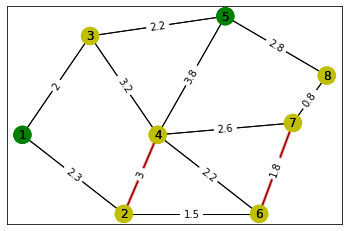

Task Allocation Algorithm Output: 
Allocating arc 2 - 4 to base station - node 1
Allocating arc 6 - 7 to base station - node 5


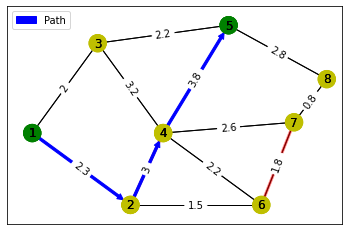

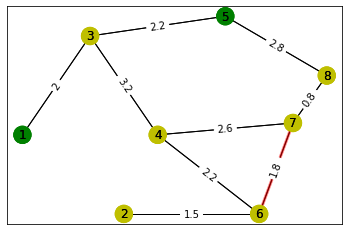

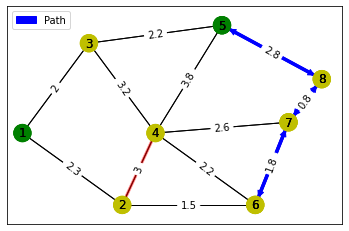

Path Scanning Algorithm Output: 


In [53]:
vehicleCapacity = 14
numNodes = 8
requiredNodes = [[2, 4], [6, 7]];
uavsInDepotNodes = [1, 1];
totalUavs = sum(uavsInDepotNodes);
numrequiredEdges = 2;
depotNodes = [1, 5];
start = time.time()
G,pos, depot_node_color = createGraph(depotNodes, requiredNodes, numNodes)
bestPathTillDesiredEdge, bestCostTillDesiredEdge = taskAllocation(G, depotNodes, requiredNodes, numrequiredEdges, uavsInDepotNodes)
# visualizePath(depotNodes, requiredNodes, numNodes, bestPathTillDesiredEdge, pathType="normal")
bestRoute, bestRouteCost = constructAndStrike(G, numrequiredEdges, requiredNodes, depotNodes, bestPathTillDesiredEdge, bestCostTillDesiredEdge, vehicleCapacity)